In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import trompy as tp

from scipy import stats

import dill

rcParams['font.family'] = 'Arial'
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.transparent'] = True
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]

savefigs = False

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")
FIGSFOLDER = Path("C:/Users/jmc010/Dropbox/Publications in Progress/Bazzino Roitman_sodium/figs")

In [2]:
with open(DATAFOLDER / "bazzino_data_for_frejus.pickle", "rb") as f:
    data = dill.load(f)

x_array = data["x_array"]
snips_photo = data["snips_photo"]
snips_vel = data["snips_vel"]

In [3]:
# to show eligible rats for this fitting
x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").id.unique()

array(['PB26', 'PB27', 'PB30', 'PB31', 'PB46', 'PB48', 'PB71', 'PB72',
       'PB73', 'PB75'], dtype=object)

Fitted parameters: [ 0.94879018 12.04737439  0.14658649]


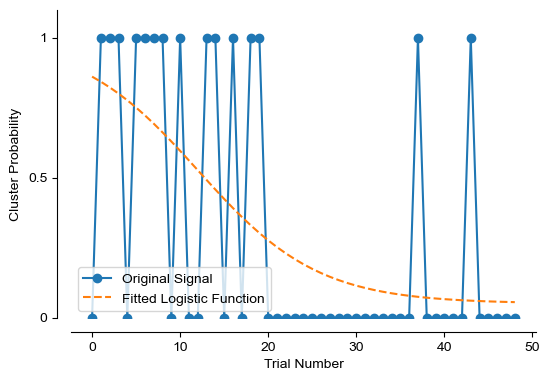

In [4]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define logistic function
def logistic(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

# Example signal with smooth transitions
x = np.linspace(0, 10, 100)
signal = 1 / (1 + np.exp(-(x - 5)))  # Logistic function

signal = x_array.query("condition == 'deplete' & infusiontype == '45NaCl' & id == 'PB46'").cluster_photo
x = np.arange(len(signal))

# Define logistic function
def logistic(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

# Fit logistic function to the signal
popt, _ = curve_fit(logistic, x, signal, p0=[1, 5, 1])  # Initial guesses for L, x0, k

# Plot the signal and the fitted function
f, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, signal, label="Original Signal", marker="o")
ax.plot(x, logistic(x, *popt), label="Fitted Logistic Function", linestyle="--")
ax.legend()
ax.set_xlabel("Trial Number")
ax.set_ylabel("Cluster Probability")
ax.set_ylim([1,-0.1])
ax.set_yticks([0, 0.5, 1], labels=["1", "0.5", "0"])

sns.despine(ax=ax, offset=10)

print("Fitted parameters:", popt)

id: <built-in function id>, params: [  0.91304348  22.65402374 -27.94407776]
id: <built-in function id>, params: [-1.95833480e-18  4.99999999e+00 -9.99999984e-01]
id: <built-in function id>, params: [ 1.01227259 12.45730322 -0.90807663]
id: <built-in function id>, params: [ 0.98251587 23.36861632 -0.36059154]
id: <built-in function id>, params: [  0.65        19.67606834 -27.3883299 ]
id: <built-in function id>, params: [ 7.66394048e-09  4.99999998e+00 -9.99999943e-01]
id: <built-in function id>, params: [  0.92857143  13.74012907 -37.34739805]
id: <built-in function id>, params: [  1.          11.50046692 -21.57905387]
id: <built-in function id>, params: [  0.94444444  17.73653451 -39.43057602]
id: <built-in function id>, params: [ 0.61467225 23.00367072 -0.12792541]
[  0.91304348  22.65402374 -27.94407776   0.76687161]
[-1.95833480e-18  4.99999999e+00 -9.99999984e-01            -inf]
[ 1.01227259 12.45730322 -0.90807663  0.64260504]
[ 0.98251587 23.36861632 -0.36059154  0.78410081]
[

C:\Users\jmc010\AppData\Local\Temp\ipykernel_24548\3203773105.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  r_squared = 1 - (ss_res / ss_tot)
C:\Users\jmc010\AppData\Local\Temp\ipykernel_24548\638883445.py:17: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))
C:\Users\jmc010\AppData\Local\Temp\ipykernel_24548\638883445.py:17: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))
C:\Users\jmc010\AppData\Local\Temp\ipykernel_24548\638883445.py:17: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))
C:\Users\jmc010\AppData\Local\Temp\ipykernel_24548\638883445.py:17: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))
C:\Users\jmc010\AppData\Local\Temp\ipykernel_24548\638883445.py:17: RuntimeWarning: overflow encountered in exp
  return L / (1 + np.exp(-k * (x - x0)))


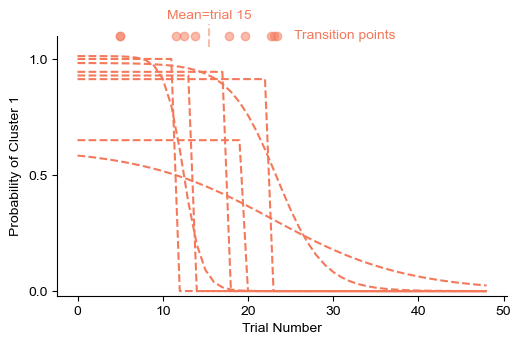

In [5]:
all_logistic_fits = []

df2_dep_45 = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").reset_index(drop=True)

for rat in df2_dep_45.id.unique():
    signal = x_array.query("id == @rat & condition == 'deplete' & infusiontype == '45NaCl'").cluster_photo
    y = np.logical_not(signal).astype(int) # inverted signal
    
    x = np.arange(len(signal))

    try:
        popt, _ = curve_fit(logistic, x, y, p0=[1, 5, -1])  # Initial guesses for L, x0, k

        print(f"id: {id}, params: {popt}")

        y_fit = logistic(x, *popt)
        ss_res = np.sum((y - y_fit) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r_squared = 1 - (ss_res / ss_tot)

    except RuntimeError as e:
        print(f"Could not fit logistic for id {id}: {e}")
        r_squared = np.nan

    all_logistic_fits.append(np.concatenate([popt, [r_squared]]))

x = np.arange(len(signal))
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]
     
f, ax = plt.subplots(figsize=(6, 4), gridspec_kw={'left': 0.2, 'right': 0.95, 'top': 0.85, 'bottom': 0.2})

for fit in all_logistic_fits:
    print(fit)
    if fit[0] < 0.5:
        continue
    ax.plot(x, logistic(x, *fit[:-1]), label="Fitted Logistic Function", linestyle="--", color=colors[2])
    
sns.despine(ax=ax)
ax.set_xlabel("Trial Number")
ax.set_ylabel("Probability of Cluster 1")

x0 = np.array(all_logistic_fits)[:,1]

ax.plot(x0, [1.1]*len(x0), marker="o", linestyle="None", color=colors[2], alpha=0.5, clip_on=False)
ax.text(np.max(x0)+2, 1.1, "Transition points", ha="left", va="center", fontsize=10, color=colors[2])

ax.plot([np.mean(x0), np.mean(x0)], [1.05, 1.15], color=colors[2], linestyle="--", alpha=0.5, clip_on=False)
ax.text(np.mean(x0), 1.16, f"Mean=trial {int(np.mean(x0))}", ha="center", va="bottom", fontsize=10, color=colors[2])

ax.set_yticks([0, 0.5, 1])
ax.set_ylim([-0.02, 1.1])

if savefigs:
    f.savefig(FIGSFOLDER / "logistic_fits_45NaCl.pdf", dpi=600, transparent=True)


In [6]:
df_fitted_params = pd.DataFrame(data = np.array(all_logistic_fits),
                                columns = ["L", "x0", "k", "r"])

df_fitted_params.insert(0, "id", df2_dep_45.id.unique())


lower, upper = 0, 50
df_fitted_params = df_fitted_params[
    (df_fitted_params['x0'] >= lower) & (df_fitted_params['x0'] <= upper)
    & (df_fitted_params['r'] >= 0.3)
    
].reset_index(drop=True)

In [7]:
df_fitted_params

,id,L,x0,k,r
0,PB26,0.913043,22.654024,-27.944078,0.766872
1,PB30,1.012273,12.457303,-0.908077,0.642605
2,PB31,0.982516,23.368616,-0.360592,0.784101
3,PB46,0.650000,19.676068,-27.388330,0.370686
4,PB71,0.928571,13.740129,-37.347398,0.718627
5,PB72,1.000000,11.500467,-21.579054,0.711765
6,PB73,0.944444,17.736535,-39.430576,0.914931


In [8]:
def realigned_trials(x_array, df_fitted_params, verbose=True):

# Realigning behavioral data to dopamine transitions
    realigned_trials = []

    for rat in x_array.id.unique():
        
        x_array_r = x_array.query("id == @rat & condition == 'deplete' & infusiontype == '45NaCl'")

        if rat not in df_fitted_params.id.unique():
            if verbose:
                print(f"Rat {rat} not found in fitted parameters, skipping.")
            realigned_trials.append([np.nan] * len(x_array_r.trial))
        else:
            transition_point = int(df_fitted_params.query("id == @rat").x0.values[0])
            realigned_trials.append(x_array_r.trial - transition_point)

    return (
        x_array
        .assign(trial_aligned=tp.flatten_list(realigned_trials))
        .dropna()
        .reset_index(drop=True)
        # .astype(int)  # Ensure the trial_aligned column is of integer type
        )
    
        
        # Update the original DataFrame
        # print(len(x_array.loc[x_array.id == rat, 'trial_aligned']))
        # x_array.loc[x_array.id == rat, 'trial_aligned'] = x_array_r['trial_aligned'].values
df2_dep_45 = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").reset_index(drop=True)

z = realigned_trials(df2_dep_45, df_fitted_params)

Rat PB27 not found in fitted parameters, skipping.
Rat PB48 not found in fitted parameters, skipping.
Rat PB75 not found in fitted parameters, skipping.


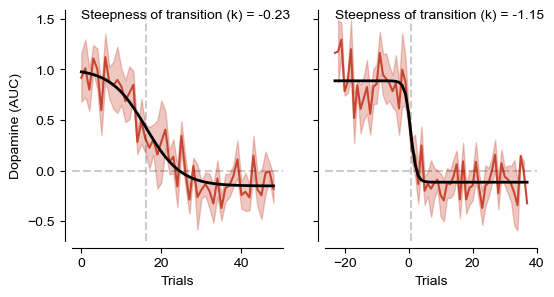

In [10]:
# make dopamine figure with trials and sigmoidal fit

def sigmoid(x, L, x0, k, b):
    """
    Sigmoid function.
    L: Maximum value of the curve
    x0: Midpoint of the sigmoid
    k: Steepness of the curve
    b: Baseline offset
    """
    return L / (1 + np.exp(-k * (x - x0))) + b

def plot_auc_and_sigmoid(df, column, ax=None, first_trial=0, include_steepness=True):
    
    if ax is None:
        f, ax = plt.subplots(figsize=(3,3))

    mean = df.groupby(column).mean(numeric_only=True).auc_snips
    sd = df.groupby(column).std(numeric_only=True).auc_snips.values
    sem = sd / np.sqrt(len(df.id.unique()))
    x, y = (mean.index, mean.values)

    ax.plot(x, y, color=colors[3])
    ax.fill_between(x, y-sem, y+sem, color=colors[3], alpha=0.3)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), -1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        ax.plot(x, y_fit, color="k", lw=2)
        if include_steepness:
            ax.text(first_trial, 1.5, "Steepness of transition (k) = {:.2f}".format(popt[2]))
    except:
        print("Failed to fit")

    ax.axhline(0, color="k", linestyle="--", alpha=0.2)
    ax.axvline(popt[1], color="k", linestyle="--", alpha=0.2)
    sns.despine(ax=ax, offset=5)

    ax.set_ylabel("Dopamine (AUC)")
    ax.set_xlabel("Trials")


f, ax = plt.subplots(ncols=2, figsize=(6, 3), sharey=True)
plot_auc_and_sigmoid(z, "trial", ax=ax[0])
plot_auc_and_sigmoid(z, "trial_aligned", ax=ax[1], first_trial=z.trial_aligned.min())

ax[1].set_ylabel("")

f.savefig(FIGSFOLDER / "realigned_transitions.png")



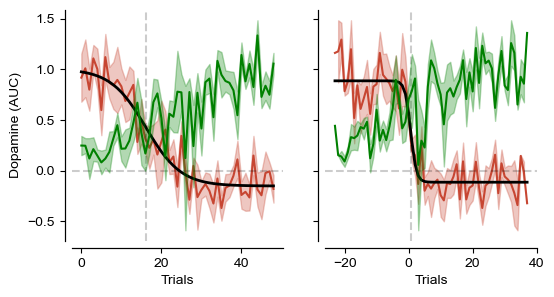

In [15]:
def plot_realigned_behaviour(df, column, ax=None, first_trial=0):
    
    if ax is None:
        f, ax = plt.subplots(figsize=(3,3))

    mean = df.groupby(column).mean(numeric_only=True).auc_vel
    sd = df.groupby(column).std(numeric_only=True).auc_vel.values
    sem = sd / np.sqrt(len(df.id.unique()))
    x, y = (mean.index, mean.values)

    ax.plot(x, y, color="green")
    ax.fill_between(x, y-sem, y+sem, color="green", alpha=0.3)
    
    sns.despine(ax=ax, offset=5)
    ax.set_yticks([])

    # ax.set_ylabel("Dopamine (AUC)")
    # ax.set_xlabel("Trials")

f, ax = plt.subplots(ncols=2, figsize=(6, 3), sharey=True)
plot_auc_and_sigmoid(z, "trial", ax=ax[0], include_steepness=False)
plot_auc_and_sigmoid(z, "trial_aligned", ax=ax[1], first_trial=z.trial_aligned.min(), include_steepness=False)

ax[1].set_ylabel("")

ax2 = ax[0].twinx()
plot_realigned_behaviour(z, "trial",ax=ax2)
f.savefig(FIGSFOLDER / "realigned_transitions_behav1.png")

ax3 = ax[1].twinx()
plot_realigned_behaviour(z, "trial_aligned",ax=ax3, first_trial=z.trial_aligned.min())
f.savefig(FIGSFOLDER / "realigned_transitions_behav2.png")
    

In [22]:
print(df2_dep_45.id.unique())
print(df_fitted_params_shuffled.id.unique())

['PB26' 'PB27' 'PB30' 'PB31' 'PB46' 'PB48' 'PB71' 'PB72' 'PB73' 'PB75']
['PB26' 'PB30' 'PB31' 'PB46' 'PB71' 'PB72' 'PB73']


In [11]:
# shuffle rows in df_fitted
# run realignment
# fit sigmoidal and add to list
# plot hist of shuffled
# calc proportion that are greater

def fit_sigmoid(df, column):
    mean = df.groupby(column).mean(numeric_only=True).auc_snips
    x, y = (mean.index, mean.values)

    try:
        popt, pcov = curve_fit(sigmoid, x, y, p0=[max(y), np.median(x), -1, min(y)], maxfev=10000)
        y_fit = sigmoid(x, *popt)
        return popt
    except:
        print("Failed to fit")
        return np.nan

df_fitted_params

real_k = fit_sigmoid(z, "trial_aligned")[2]

num_repeats = 1000
shuffled_k = np.zeros(num_repeats)
for i in range(num_repeats):
    shuffled_x0s = df_fitted_params.x0.values
    np.random.shuffle(shuffled_x0s)
    df_fitted_params_shuffled = df_fitted_params.assign(x0=shuffled_x0s)
    z_temp = realigned_trials(df2_dep_45, df_fitted_params_shuffled, verbose=False)
    shuffled_k[i] = fit_sigmoid(z_temp, "trial_aligned")[2]

print(real_k)



-1.1461410399049892


Text(0.5, 0, 'Steepness of transition (k)')

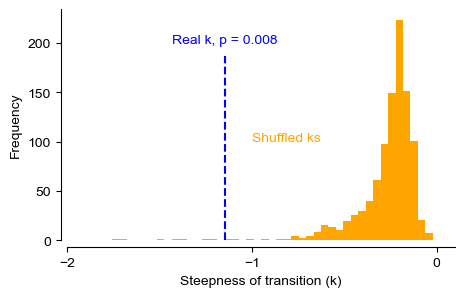

In [36]:
color_shuf = "orange"
color_real = "blue"

bins = np.linspace(-2, 2, 100)
f, ax = plt.subplots(figsize=(5, 3))

ax.hist(shuffled_k, bins=bins, color=color_shuf)
ax.axvline(real_k, ymax=0.8, linestyle="--", color=color_real)

sns.despine(ax=ax, offset=5)
ax.set_xlim(-2, 0.1)
ax.set_xticks([-2, -1, 0])
ax.text(real_k, 200,
        "Real k, p = {:2.3f}".format(1 - np.sum(shuffled_k > real_k) / num_repeats),
        ha="center",
        color=color_real)

ax.text(-1, 100, "Shuffled ks", color=color_shuf)

ax.set_ylabel("Frequency")
ax.set_xlabel("Steepness of transition (k)")

In [ ]:
# to calculate difference before and after to see whether realigning worked

transition = 0
before = z.query("trial_aligned < @transition").auc_vel.mean()
after = z.query("trial_aligned >= @transition").auc_vel.mean()
print(f"Before transition: {before:.2f}, After transition: {after:.2f}, Difference: {after - before:.2f}")

In [ ]:
for transition in np.arange(1, 48):
    before = z.query("trial < @transition").auc_vel.mean()
    after = z.query("trial >= @transition").auc_vel.mean()
    print(f"{transition}, Before transition: {before:.2f}, After transition: {after:.2f}, Difference: {after - before:.2f}")